<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Ознакомление-с-данными" data-toc-modified-id="1.-Ознакомление-с-данными-1">1. Ознакомление с данными</a></span></li><li><span><a href="#2.-Предварительная-обработка-данных" data-toc-modified-id="2.-Предварительная-обработка-данных-2">2. Предварительная обработка данных</a></span></li><li><span><a href="#3.-Определение-целевой-метрики" data-toc-modified-id="3.-Определение-целевой-метрики-3">3. Определение целевой метрики</a></span></li><li><span><a href="#4.-Подготовка-данных-для-baseline-модели." data-toc-modified-id="4.-Подготовка-данных-для-baseline-модели.-4">4. Подготовка данных для baseline-модели.</a></span></li><li><span><a href="#5.-Создание-baseline-модели" data-toc-modified-id="5.-Создание-baseline-модели-5">5. Создание baseline-модели</a></span></li><li><span><a href="#6.-Расчет-метрик-для-baseline-модели" data-toc-modified-id="6.-Расчет-метрик-для-baseline-модели-6">6. Расчет метрик для baseline-модели</a></span></li><li><span><a href="#6.-Подготовка-данных-для-нейронной-сети." data-toc-modified-id="6.-Подготовка-данных-для-нейронной-сети.-7">6. Подготовка данных для нейронной сети.</a></span></li><li><span><a href="#7.-Обучение-нейронной-сети" data-toc-modified-id="7.-Обучение-нейронной-сети-8">7. Обучение нейронной сети</a></span></li><li><span><a href="#8.-Расчет-и-сравнение-метрик" data-toc-modified-id="8.-Расчет-и-сравнение-метрик-9">8. Расчет и сравнение метрик</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-10">Общий вывод</a></span></li></ul></div>

#  Определение жанра музыки по изображению обложки альбома

В данной работе исследуюется возможность определения жанра музыкального альбома, основываясь на изображении обложки альбома. В работе используются данные с сайта MusicBrainz: 7800 альбомов разбитых на 10 жанров.<br>
Стек: python, sklearn, faiss, pytorch, torchvision, fastai.

In [ ]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 10.0 MB/s eta 0:00:00


In [ ]:
import os
import zipfile
import torch
import faiss
import hashlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as transforms
from torchvision.models import resnet50
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from fastai.callback.tracker import EarlyStoppingCallback
from torch.nn import CrossEntropyLoss
from fastai.vision.all import *

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

## 1. Ознакомление с данными

In [ ]:
folder_with_zip = '/content/music'
folder_with_unzip = '/content/music/data'
os.makedirs(folder_with_unzip, exist_ok=True)

In [ ]:
for file_name in os.listdir(folder_with_zip):
    if file_name.endswith('.zip'):
        zip_path = os.path.join(folder_with_zip, file_name)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(folder_with_unzip)
print("Извлечение завершено.")

Извлечение завершено.


In [ ]:
def load_image(image_path):
    with Image.open(image_path) as img:
        img = img.convert('RGB')
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        return transform(img)

In [ ]:
data = []

for root, dirs, files in os.walk(folder_with_unzip):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(root, file)
            genre = os.path.basename(root)
            data.append({'path': path, 'genre': genre, 'image': load_image(path)})

df = pd.DataFrame(data)
print(df.head())

                                                                 path  genre  \
0  /content/music/data/anime/50a7aaaf-fc77-4408-86b7-dceb098533d6.png  anime   
1  /content/music/data/anime/30ece4e8-0ba5-48d5-8b3b-57e81fb5d342.png  anime   
2  /content/music/data/anime/b2fffffd-541e-463b-99d3-7cae62983dd8.png  anime   
3  /content/music/data/anime/5ca23b05-63cb-4ef1-89f7-3d8c64b63854.png  anime   
4  /content/music/data/anime/c4e0f0aa-fd4d-400a-a053-16cb63ffdf76.png  anime   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
#  Создаем эмбеддинги
model = resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

df['embeddings'] = df['image'].apply(lambda x: model(x.unsqueeze(0)).flatten().detach().numpy())
print("Эмбеддинги извлечены.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]


Эмбеддинги извлечены.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7748 entries, 0 to 7747
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        7748 non-null   object
 1   genre       7748 non-null   object
 2   image       7748 non-null   object
 3   embeddings  7748 non-null   object
 4   hash        7748 non-null   object
dtypes: object(5)
memory usage: 302.8+ KB


In [ ]:
df['genre'].value_counts()

genre
country        1486
anime          1189
classical       955
jazz            821
pop             803
edm             719
reggae          581
disco           468
black metal     450
rap             328
Name: count, dtype: int64

Классы не сбалансированы

Выведем по 2 обложки каждого жанра

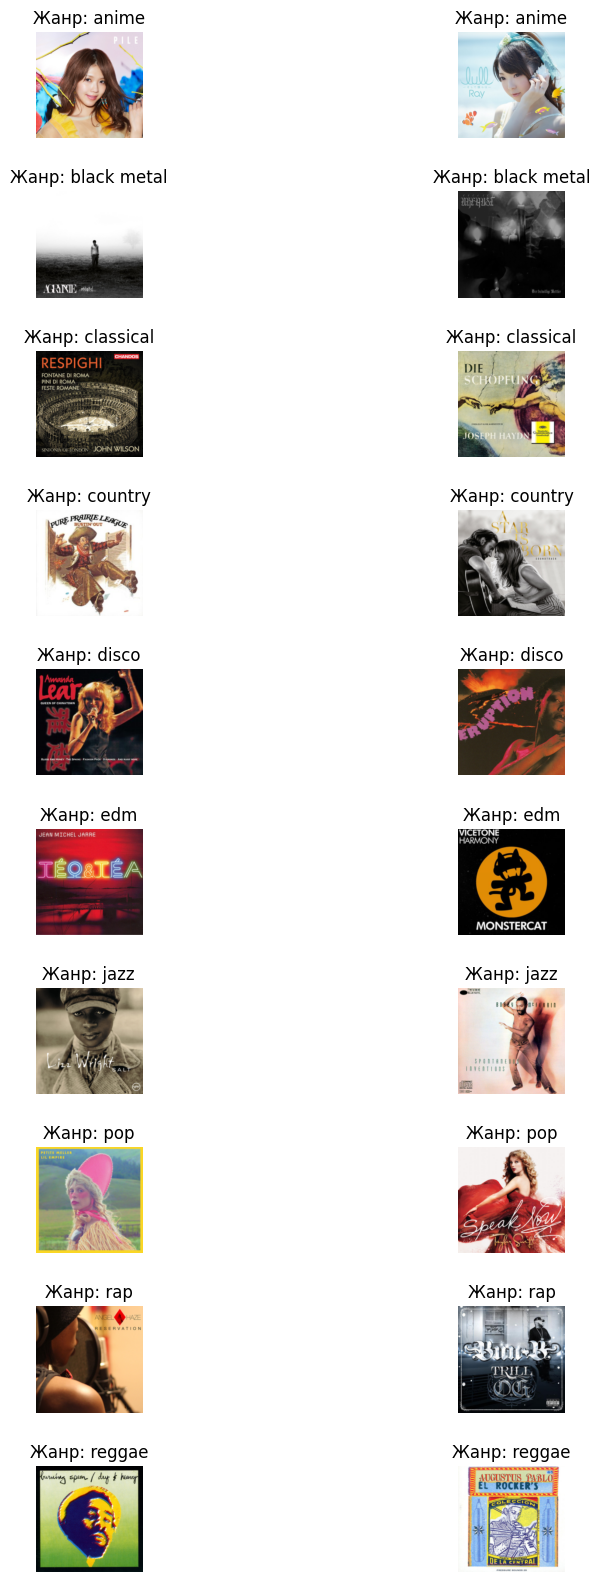

In [ ]:
sampled_df = df.groupby('genre').apply(lambda x: x.sample(2)).reset_index(drop=True)

def tensor_to_image(tensor):
    np_image = tensor.numpy()
    np_image = np.transpose(np_image, (1, 2, 0))
    np_image = np.clip(np_image, 0, 1)
    return np_image

fig, axes = plt.subplots(nrows=len(sampled_df['genre'].unique()), ncols=2, figsize=(10, 20))
fig.subplots_adjust(hspace=0.5)


for idx, row in sampled_df.iterrows():
    ax = axes[idx // 2, idx % 2]
    image = tensor_to_image(row['image'])
    ax.imshow(image)
    ax.set_title(f"Жанр: {row['genre']}")
    ax.axis('off')

plt.show()

Вывод: Данные загружены, сформированы эмбеддинги.7800 изображения представляют 10 жанров. Классы не сбалансированы.

## 2. Предварительная обработка данных

Проверим, есть ли среди изображений задублированные. Дубли будем определять по хэшу файла.

In [ ]:
def file_hash(filepath):
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

df['hash'] = df['path'].apply(file_hash)
duplicates = df[df['hash'].duplicated(keep=False)]
print(duplicates)

                                                                          path  \
292         /content/music/data/anime/bf9fe9d3-9393-4d02-9e21-db866297241b.png   
369         /content/music/data/anime/680519a3-9a87-428b-8d3b-c7ef4b005de6.png   
441         /content/music/data/anime/16072b25-550c-43b3-9cd3-6f575ec0a0ee.png   
467         /content/music/data/anime/10d9da17-1902-43d2-898e-ebc7563608bb.png   
558         /content/music/data/anime/48f2154c-2867-4253-9076-bc5d0aa800db.png   
...                                                                        ...   
7075  /content/music/data/black metal/151a2a52-ffe7-35e1-9fa2-b03d1cd86fb7.png   
7224       /content/music/data/reggae/5c4f2c7c-8412-39fa-9468-23c52e285cd7.png   
7480       /content/music/data/reggae/74d376f0-52b4-429c-adc6-0567339b0e35.png   
7662       /content/music/data/reggae/115b13b6-39de-4b92-b3d6-0221861ed572.png   
7693       /content/music/data/reggae/429d2930-c542-40ca-8a36-965755a98f7b.png   

            gen

Удалим дубликаты

In [ ]:
df = df.drop_duplicates(subset='hash', keep='first')
df = df.reset_index(drop=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7748 entries, 0 to 7747
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        7748 non-null   object
 1   genre       7748 non-null   object
 2   image       7748 non-null   object
 3   embeddings  7748 non-null   object
 4   hash        7748 non-null   object
dtypes: object(5)
memory usage: 302.8+ KB


Данные уменьшились на 52 изображения

Вывод: обнаружены 52 изображения дублированные 101 раз. Дубли удалены.

## 3. Определение целевой метрики

В этой задаче для нас важна точность определения жанра, поэтому в качестве метрики будем использовать  accuracy

## 4. Подготовка данных для baseline-модели.

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['genre'])

In [ ]:
train_embeddings = np.array(train_df['embeddings'].tolist()).astype('float32')
test_embeddings = np.array(test_df['embeddings'].tolist()).astype('float32')

## 5. Создание baseline-модели

In [ ]:
dimension = train_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(train_embeddings)

print("Индекс для поиска ближайших соседей создан.")

Индекс для поиска ближайших соседей создан.


In [ ]:
def classify_by_nearest_neighbors(index, test_embeddings, train_labels, k=9):
    distances, indices = index.search(test_embeddings, k)
    predicted_labels = []
    for idx in indices:
        nearest_labels = [train_labels[i] for i in idx]
        predicted_label = max(set(nearest_labels), key=nearest_labels.count)
        predicted_labels.append(predicted_label)
    return predicted_labels

train_labels = train_df['genre'].tolist()
predicted_labels = classify_by_nearest_neighbors(index, test_embeddings, train_labels)

test_df['predicted_genre'] = predicted_labels

## 6. Расчет метрик для baseline-модели

In [ ]:
accuracy_faiss = accuracy_score(test_df['genre'], test_df['predicted_genre'])
print(f"Точность модели faiss: {accuracy_faiss:.2f}")

report = classification_report(test_df['genre'], test_df['predicted_genre'])
print("Подробный отчет по классификации:")
print(report)

Точность модели faiss: 0.48
Подробный отчет по классификации:
              precision    recall  f1-score   support

       anime       0.61      0.68      0.64       237
 black metal       0.66      0.69      0.67        90
   classical       0.56      0.69      0.62       190
     country       0.46      0.58      0.51       297
       disco       0.21      0.16      0.18        93
         edm       0.59      0.46      0.52       139
        jazz       0.31      0.20      0.25       164
         pop       0.35      0.33      0.34       159
         rap       0.56      0.22      0.31        65
      reggae       0.31      0.31      0.31       116

    accuracy                           0.48      1550
   macro avg       0.46      0.43      0.43      1550
weighted avg       0.47      0.48      0.47      1550



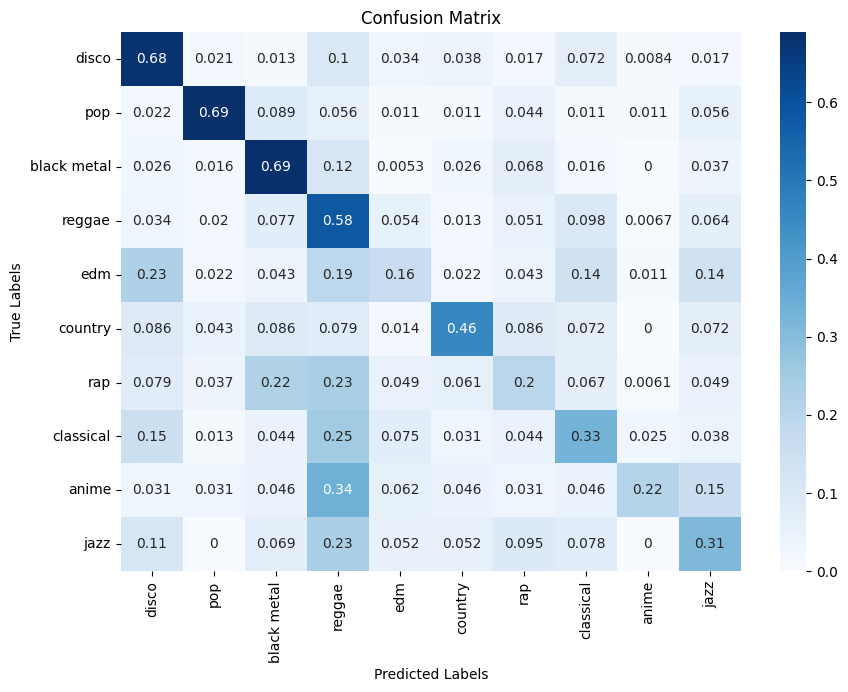

In [ ]:
conf_mat = confusion_matrix(test_df['genre'], predicted_labels,  normalize='true')

plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, cmap='Blues',  xticklabels=set(test_df['genre']), yticklabels=set(test_df['genre']))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Вывод: Baseline модель на основе faiss продемонстрировала низкую точность на тестовых данных - 0.48 accuracy. Наибольшую точность модель продемострироровала в предсказании следующих жанров - disco, pop, black metal и reggae. Стоит обратит внимание, что это жанры (кроме pop) наименее представленные в датасете.

## 6. Подготовка данных для нейронной сети.

In [ ]:
music_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('path'),
    get_y=ColReader('genre'),
    splitter=RandomSplitter(valid_pct=0.2, seed=SEED),
    item_tfms=Resize(460)
)

In [ ]:
dls = music_block.dataloaders(train_df, bs=32)

## 7. Обучение нейронной сети

В ходе экспериментов были рассмотрены модели resnet18, resnet34, resnet101, densenet121 с dropout и без. Но по сравнению с resnet50 они показали худшие результаты на валидации. Поэтому я оставил только лучшую сеть, чтобы при финальном прогоне сэкономить время расчета.

In [ ]:
learn = vision_learner(dls, resnet50, metrics=[accuracy], ps=0.5)
learn.lr_find()


In [ ]:
learn.fine_tune(100, base_lr=1e-3, cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3))

epoch,train_loss,valid_loss,accuracy,time
0,1.981984,1.318775,0.612591,18:42


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,accuracy,time
0,1.147254,1.075079,0.651332,25:50
1,0.933634,1.027239,0.680387,25:53
2,0.718697,0.992151,0.696529,27:34
3,0.600541,0.978901,0.692494,27:58
4,0.485078,0.976419,0.696529,27:50
5,0.369763,0.979004,0.702986,27:35
6,0.288431,1.015392,0.696529,27:52


No improvement since epoch 3: early stopping


## 8. Расчет и сравнение метрик

Проверим работу сети на тестовых данных

In [ ]:
test_df = test_df.reset_index(drop=True)

In [ ]:
label2index = {v:k for k, v in enumerate(learn.dls.vocab)}
test_df['genre_indices'] = test_df['genre'].map(label2index)

In [ ]:
test_dl = learn.dls.test_dl(test_df, with_labels=True)

test_preds, test_targets = learn.get_preds(dl=test_dl)
test_preds_max = np.argmax(test_preds.numpy(), axis=1)

accuracy_test = accuracy_score(test_df['genre_indices'], test_preds_max)
print(f"Точность на тестовом наборе: {accuracy_test:.2f}")

Точность на тестовом наборе: 0.65


Анализ финальной модели.

In [ ]:
print(classification_report(test_targets.numpy(), test_preds_max))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79       237
           1       0.82      0.78      0.80        90
           2       0.76      0.83      0.79       190
           3       0.58      0.74      0.65       297
           4       0.52      0.29      0.37        93
           5       0.65      0.60      0.62       139
           6       0.53      0.60      0.56       164
           7       0.57      0.38      0.46       159
           8       0.69      0.38      0.50        65
           9       0.52      0.70      0.59       116

    accuracy                           0.65      1550
   macro avg       0.65      0.61      0.61      1550
weighted avg       0.65      0.65      0.64      1550



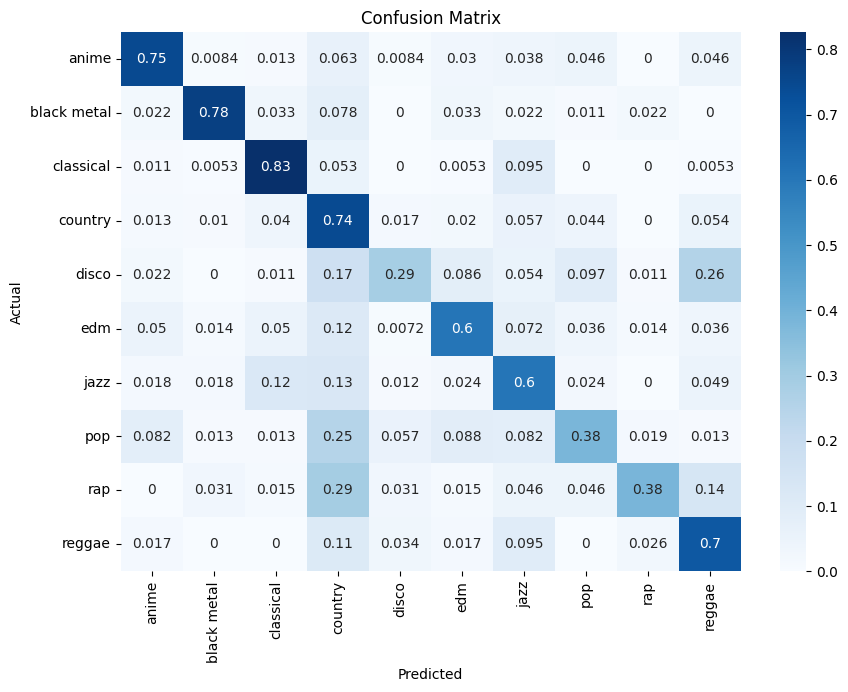

In [ ]:
class_names = learn.dls.vocab

test_labels_actual = [class_names[int(x)] for x in test_targets.numpy()]
test_labels_pred = [class_names[x] for x in test_preds_max]

cm = confusion_matrix(test_labels_actual, test_labels_pred, labels=class_names, normalize='true')

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

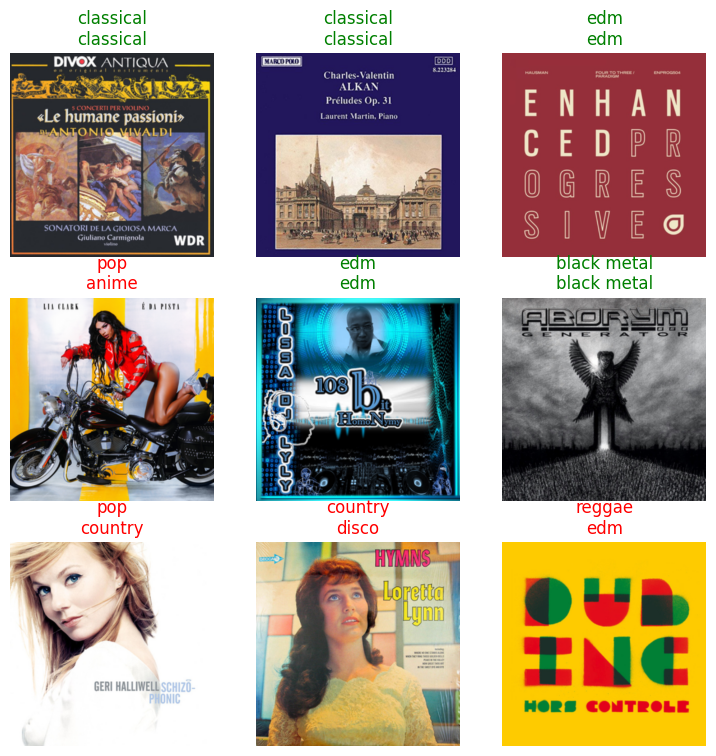

In [ ]:
learn.show_results()

Вывод: на тестовых данных модель показала результат 0.65 accuracy, т.к. на валидации результат 0.69, то модель получилась несколько переобученной. Модель довольно точно определяет жанры anime, black metal  и classic, с другой стороны для disco, pop и  jazz у модели возникают сложности с определением.

## Общий вывод

- В данной работе была изучена возможность пресказания жанра по обложке музыкального альбом
- было использовано 7800 альбомов разбитых на 10 жанров, 52 альбома были задублированы, классы несбалансированы
- в качестве baseline была использована модель faiss, которая показала 0.48 accuracy
- было обучено несколько сетей, но в работе оставлена одна resnet50 с лучшей метрикой accuracy на валидационных данных - 0.69
- на тестовых данных модель показала результат 0.65, что говорит о некотором переобучении
- модель довольно точно определяет жанры anime, black metal  и classic, с другой стороны для disco, pop и  jazz у модели возникают сложности с определением.

Дальнейшие рекомендации по улучшению модели:
 - обогащение данных, за счет добавление большего количество альбом для жанров, преддставленных меньше всего, а тек же для тех жанров, для которых модель совершает больше всего ошибок
 - обогащение данных задними обложками альбомов, а так эмбеддингами текстов, которые указаны на передней и задней обложках
 - попробовать уменьшить переобучение путем регуляризации и более раней остановкой